## Predictive Modeling (Odds Movement Analysis)
* Can be used to explore effect of different degrees of opening to closing line movement on prediction quality
* Hard court model inclusion range:2015-2019
* Clay court model inclusion range: 2012-2019

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.dummy import DummyRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
#from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load and Filter Data

Filtering parameters identical to in dummy/simple modeling stage. 

In [2]:
# This is the file and analysis data range used for variable time range analyses for either surface
df = pd.read_csv('../../data/processed_data/df_player_all_for_EDA.csv')
df.head()

t_id  t_ident         t_nm t_co  t_GMT_diff  t_surf  t_ind  t_alt  \
0  20190605       91  Tour Finals  GBR           1       2      1      0   
1  20190605       91  Tour Finals  GBR           1       2      1      0   
2  20190605       91  Tour Finals  GBR           1       2      1      0   
3  20190605       91  Tour Finals  GBR           1       2      1      0   
4  20190605       91  Tour Finals  GBR           1       2      1      0   

   t_draw_sz  t_lvl  ...  p_df_SvPtsWon%_ratio_l60_tw_ss_IO_diff  \
0          8      3  ...                                   -0.02   
1          8      3  ...                                    0.02   
2          8      3  ...                                   -0.01   
3          8      3  ...                                    0.01   
4          8      3  ...                                   -0.03   

   p_df_SvPtsWon%_ratio_l10_tw_ss_IO_diff  \
0                                   -0.01   
1                                    0.01   
2                                    0.01   
3                                   -0.01   
4                                   -0.02   

  p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_diff  \
0                                       -0.01   
1                                        0.01   
2                                        0.00   
3                                        0.00   
4                                       -0.05   

   p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_diff  \
0                                        -0.01   
1                                         0.01   
2                                         0.01   
3                                        -0.01   
4                                        -0.03   

   p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_diff  \
0                                           -0.02   
1                                            0.02   
2                                           -0.01   
3                                            0.01   
4                                           -0.03   

   p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_diff  \
0                                           -0.01   
1                                            0.01   
2                                            0.01   
3                                           -0.01   
4                                           -0.02   

   p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_csp_diff  \
0                                            -0.02   
1                                             0.02   
2                                             0.00   
3                                             0.00   
4                                            -0.05   

   p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_csp_diff  \
0                                             0.00   
1                                             0.00   
2                                             0.01   
3                                            -0.01   
4                                            -0.03   

   p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff  \
0                                              -0.02    
1                                               0.02    
2                                              -0.01    
3                                               0.01    
4                                              -0.04    

  p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff  
0                                               0.00  
1                                               0.00  
2                                               0.00  
3                                               0.00  
4                                              -0.03  

[5 rows x 689 columns]

In [65]:
# Select Surface matches only 
#df_filter = df.loc[(df["t_surf"] == 1)] #clay
df_filter = df.loc[(df["t_surf"] == 2)] #hard

In [66]:
# Select match year inclusion for modeling. 
# 2009-2010 reserved for stats accrual (ie, earliest year included for modeling in any variant here is 2011)
#df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017) | (df_filter["m_yr"] == 2016) | (df_filter["m_yr"] == 2015)| (df_filter["m_yr"] == 2014) | (df_filter["m_yr"] == 2013) | (df_filter["m_yr"] == 2012) | (df_filter["m_yr"] == 2011)]
#df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017) | (df_filter["m_yr"] == 2016) | (df_filter["m_yr"] == 2015)| (df_filter["m_yr"] == 2014) | (df_filter["m_yr"] == 2013) | (df_filter["m_yr"] == 2012)]
#df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017) | (df_filter["m_yr"] == 2016) | (df_filter["m_yr"] == 2015)| (df_filter["m_yr"] == 2014) | (df_filter["m_yr"] == 2013)]
#df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017) | (df_filter["m_yr"] == 2016) | (df_filter["m_yr"] == 2015)| (df_filter["m_yr"] == 2014)]
df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017) | (df_filter["m_yr"] == 2016) | (df_filter["m_yr"] == 2015)]
#df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017) | (df_filter["m_yr"] == 2016)]
#df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017)]
#df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018)]
#df_filter = df_filter.loc[(df_filter["m_yr"] == 2019)]

In [67]:
# Now also will remove BOTH players from individual matches remaining in the surface-specific sample already filtered by year range
# where one or both players has played N or fewer matches prior to the one to be predicted. 
df_low_pass = df_filter.loc[df_filter['p_matches_ss'] <= 20, 'm_num']
df_filter = df_filter[~df_filter['m_num'].isin(df_low_pass)]

In [68]:
# Create column with absolute IWP movement for each player, from Opening to Closing (Pinnacle Sports Lines)
df_filter["IWP_change"] = abs(df_filter["p_PS_C_IP"] - df_filter["p_PS_O_IP"])
df_filter["IWP_change"].max()

34.370000000000005

In [69]:
# Filter out matches with n% or greater movement from Opening to Closing
df_filter = df_filter.loc[(df_filter["IWP_change"] < 2)] #filter out (both players in a given match with) O to P change >n%

In [ ]:
df_filter.info()

In [ ]:
#df_filter.to_csv('../../data/df_filter.csv', index=False)

In [70]:
#Pared down to just the predictive features and the target feature itself 
# All features are derived from data available prior to any given match being predicted on. No data leakage!

df_model1 = df_filter[['p_tot_pts_won%', 't_ind', 't_alt', 't_draw_sz', 't_lvl', 'm_bestof', 'm_rd_num', 'p_ent', 'p_age', 't_1st_sv_in%_ratio', 't_1st_sv_in%_yielded_ratio', 't_sv_pts_won%_ratio', 't_ret_pts_won%_ratio', 't_1st_sv_pts_won%_ratio', 't_1st_ret_pts_won%_ratio', 't_2nd_sv_pts_won%_ratio', 't_2nd_ret_pts_won%_ratio', 't_ace%_ratio', 't_aced%_ratio', 't_df%_ratio', 't_df_induce%_ratio', 't_bp_save%_ratio', 't_bp_conv%_ratio', 'p_rk_diff', 'p_log_rk_diff', 'p_rk_pts_diff', 'p_ent_diff', 'p_hd_diff', 'p_ht_diff', 'p_age_diff', 'p_HCA', 'p_HCA_diff', 'p_tot_time_l7d_tw_diff', 'p_tot_pts_l7d_tw_diff', 'p_body_battery_t_tw_diff', 'p_body_battery_pts_tw_diff', 'p_matches_ss_diff', 'p_matches_nss_diff', 'p_surf_chg_diff', 'p_tz_chg_diff', 'p_H2H_w_ss_diff', 'p_H2H_w_nss_diff', 'p_H2H_tot_pts_won%_ss_diff', 'p_H2H_tot_pts_won%_nss_diff', 'p_tot_pts_won%_l60_tw_ss_diff', 'p_tot_pts_won%_l10_tw_ss_diff', 'p_tot_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_tot_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_tot_pts_won%_l60_tw_ss_IO_diff', 'p_tot_pts_won%_l10_tw_ss_IO_diff', 'p_tot_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_tot_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_sv_pts_won%_l60_tw_ss_diff', 'p_sv_pts_won%_l10_tw_ss_diff', 'p_sv_pts_won%_l60_tw_ss_IO_diff', 'p_sv_pts_won%_l10_tw_ss_IO_diff', 'p_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_diff', 'p_1st_sv_pts_won%_l10_tw_ss_diff', 'p_1st_sv_pts_won%_l60_tw_ss_IO_diff', 'p_1st_sv_pts_won%_l10_tw_ss_IO_diff', 'p_1st_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_IO_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_IO_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_l60_tw_ss_diff', 'p_1st_sv%_l10_tw_ss_diff', 'p_1st_sv%_l60_tw_ss_IO_diff', 'p_1st_sv%_l10_tw_ss_IO_diff', 'p_1st_sv%_l60_tw_ss_SOS_adj_diff', 'p_1st_sv%_l10_tw_ss_SOS_adj_diff', 'p_1st_sv%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_sv%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_sv%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l60_tw_ss_diff', 'p_1st_sv%_yielded_l10_tw_ss_diff', 'p_1st_sv%_yielded_l60_tw_ss_IO_diff', 'p_1st_sv%_yielded_l10_tw_ss_IO_diff', 'p_1st_sv%_yielded_l60_tw_ss_SOS_adj_diff', 'p_1st_sv%_yielded_l10_tw_ss_SOS_adj_diff', 'p_1st_sv%_yielded_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_pts_won%_l60_tw_ss_diff', 'p_ret_pts_won%_l10_tw_ss_diff', 'p_ret_pts_won%_l60_tw_ss_IO_diff', 'p_ret_pts_won%_l10_tw_ss_IO_diff', 'p_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_diff', 'p_1st_ret_pts_won%_l10_tw_ss_diff', 'p_1st_ret_pts_won%_l60_tw_ss_IO_diff', 'p_1st_ret_pts_won%_l10_tw_ss_IO_diff', 'p_1st_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_IO_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_IO_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ace%_l60_tw_ss_diff', 'p_ace%_l10_tw_ss_diff', 'p_ace%_l60_tw_ss_IO_diff', 'p_ace%_l10_tw_ss_IO_diff', 'p_ace%_l60_tw_ss_SOS_adj_diff', 'p_ace%_l10_tw_ss_SOS_adj_diff', 'p_ace%_l60_tw_ss_IO_SOS_adj_diff', 'p_ace%_l10_tw_ss_IO_SOS_adj_diff', 'p_ace%_l60_tw_ss_SOS_csp_adj_diff', 'p_ace%_l10_tw_ss_SOS_csp_adj_diff', 'p_ace%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ace%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_aced%_l60_tw_ss_diff', 'p_aced%_l10_tw_ss_diff', 'p_aced%_l60_tw_ss_IO_diff', 'p_aced%_l10_tw_ss_IO_diff', 'p_aced%_l60_tw_ss_SOS_adj_diff', 'p_aced%_l10_tw_ss_SOS_adj_diff', 'p_aced%_l60_tw_ss_IO_SOS_adj_diff', 'p_aced%_l10_tw_ss_IO_SOS_adj_diff', 'p_aced%_l60_tw_ss_SOS_csp_adj_diff', 'p_aced%_l10_tw_ss_SOS_csp_adj_diff', 'p_aced%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_aced%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df%_l60_tw_ss_diff', 'p_df%_l10_tw_ss_diff', 'p_df%_l60_tw_ss_IO_diff', 'p_df%_l10_tw_ss_IO_diff', 'p_df%_l60_tw_ss_SOS_adj_diff', 'p_df%_l10_tw_ss_SOS_adj_diff', 'p_df%_l60_tw_ss_IO_SOS_adj_diff', 'p_df%_l10_tw_ss_IO_SOS_adj_diff', 'p_df%_l60_tw_ss_SOS_csp_adj_diff', 'p_df%_l10_tw_ss_SOS_csp_adj_diff', 'p_df%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_df%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df_induce%_l60_tw_ss_diff', 'p_df_induce%_l10_tw_ss_diff', 'p_df_induce%_l60_tw_ss_IO_diff', 'p_df_induce%_l10_tw_ss_IO_diff', 'p_df_induce%_l60_tw_ss_SOS_adj_diff', 'p_df_induce%_l10_tw_ss_SOS_adj_diff', 'p_df_induce%_l60_tw_ss_IO_SOS_adj_diff', 'p_df_induce%_l10_tw_ss_IO_SOS_adj_diff', 'p_df_induce%_l60_tw_ss_SOS_csp_adj_diff', 'p_df_induce%_l10_tw_ss_SOS_csp_adj_diff', 'p_df_induce%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_df_induce%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_save%_l60_tw_ss_diff', 'p_bp_save%_l10_tw_ss_diff', 'p_bp_save%_l60_tw_ss_IO_diff', 'p_bp_save%_l10_tw_ss_IO_diff', 'p_bp_save%_l60_tw_ss_SOS_adj_diff', 'p_bp_save%_l10_tw_ss_SOS_adj_diff', 'p_bp_save%_l60_tw_ss_IO_SOS_adj_diff', 'p_bp_save%_l10_tw_ss_IO_SOS_adj_diff', 'p_bp_save%_l60_tw_ss_SOS_csp_adj_diff', 'p_bp_save%_l10_tw_ss_SOS_csp_adj_diff', 'p_bp_save%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_save%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_conv%_l60_tw_ss_diff', 'p_bp_conv%_l10_tw_ss_diff', 'p_bp_conv%_l60_tw_ss_IO_diff', 'p_bp_conv%_l10_tw_ss_IO_diff', 'p_bp_conv%_l60_tw_ss_SOS_adj_diff', 'p_bp_conv%_l10_tw_ss_SOS_adj_diff', 'p_bp_conv%_l60_tw_ss_IO_SOS_adj_diff', 'p_bp_conv%_l10_tw_ss_IO_SOS_adj_diff', 'p_bp_conv%_l60_tw_ss_SOS_csp_adj_diff', 'p_bp_conv%_l10_tw_ss_SOS_csp_adj_diff', 'p_bp_conv%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_conv%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff',
                              'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_SOS_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_SOS_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_IO_SOS_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_IO_SOS_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_SOS_csp_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_SOS_csp_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_SOS_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_SOS_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_IO_SOS_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_IO_SOS_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_SOS_csp_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_SOS_csp_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_SOS_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_SOS_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_IO_SOS_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_IO_SOS_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_SOS_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_SOS_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_IO_SOS_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_IO_SOS_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_IO_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_IO_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_IO_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_IO_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_AVG_C_IP_l60_tw_ss_SOS_adj_diff', 'p_AVG_C_IP_l10_tw_ss_SOS_adj_diff', 'p_AVG_C_IP_l60_tw_ss_IO_SOS_adj_diff', 'p_AVG_C_IP_l10_tw_ss_IO_SOS_adj_diff', 'p_AVG_C_IP_l60_tw_nss_SOS_adj_diff', 'p_AVG_C_IP_l10_tw_nss_SOS_adj_diff', 'p_ace_df%_ratio_l60_tw_ss_diff', 'p_ace_df%_ratio_l10_tw_ss_diff', 'p_ace_df%_ratio_l60_tw_ss_IO_diff', 'p_ace_df%_ratio_l10_tw_ss_IO_diff', 'p_ace_df%_ratio_l60_tw_ss_SOS_adj_diff', 'p_ace_df%_ratio_l10_tw_ss_SOS_adj_diff', 'p_ace_df%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_ace_df%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_ace_df%_ratio_l60_tw_ss_SOS_adj_csp_diff', 'p_ace_df%_ratio_l10_tw_ss_SOS_adj_csp_diff', 'p_ace_df%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff', 'p_ace_df%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_IO_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_IO_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_IO_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_IO_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_SOS_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_SOS_adj_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_SOS_csp_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_SOS_csp_adj_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_csp_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_csp_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff']]

In [ ]:
#df_model1.info()

In [ ]:
#df_model1.to_csv('../data/df_model1.csv', index=False)

### Data Split for Modeling

Identical split as for dummy/simple modeling

In [71]:
len(df_model1) * .75, len(df_model1) * .25

(3184.5, 1061.5)

In [72]:
#Replicates EXACT train-test split from dummy and simpler modeling
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='p_tot_pts_won%'), 
                                                    df_model1["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [73]:
y_train.shape, y_test.shape

((3184,), (1062,))

In [74]:
y_train

21035    44.87
16004    57.55
15950    56.60
20254    56.07
10164    56.93
         ...  
19707    43.20
16920    55.04
5107     46.96
20718    62.14
11516    50.48
Name: p_tot_pts_won%, Length: 3184, dtype: float64

In [75]:
X_train.shape, X_test.shape

((3184, 367), (1062, 367))

## Gradient Boosting Regression Model

### Gradient Boosting Model: Hyperparameter Grid Search

In [86]:
#Define pipeline 
GB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    GradientBoostingRegressor(random_state= 47)
)

In [87]:
GB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'gradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estim

In [88]:
#Define Grid Parameters -Hard Court Versions

n_est = [135, 140]
learning_rate = [.035, .04]
max_depth = [3]
max_features = [15]

grid_params = {
        'gradientboostingregressor__n_estimators': n_est,
        'standardscaler': [None],
        'simpleimputer__strategy': ['median'],
        'gradientboostingregressor__learning_rate': learning_rate,
        'gradientboostingregressor__max_depth': max_depth,
        'gradientboostingregressor__max_features': max_features
}
grid_params

# First Run 
# n_est = [125, 130, 135] 
# learning_rate = [.03, .035, .04] .03
# max_depth = [3, 4, 5] 3
# max_features = [12, 13, 14] 14

#Hyperparameters grids are centered on best params for the 2015-2019 version of the hard court model, but allow a little wiggle room for slightly different 
#optimizations for different year range inclusions

{'gradientboostingregressor__n_estimators': [135, 140],
 'standardscaler': [None],
 'simpleimputer__strategy': ['median'],
 'gradientboostingregressor__learning_rate': [0.035, 0.04],
 'gradientboostingregressor__max_depth': [3],
 'gradientboostingregressor__max_features': [15]}

In [ ]:
#Define Grid Parameters -Clay Court Versions

# n_est = [120, 125]
# learning_rate = [.035, .04]
# max_depth = [2]
# max_features = [13]

# grid_params = {
#         'gradientboostingregressor__n_estimators': n_est,
#         'standardscaler': [None],
#         'simpleimputer__strategy': ['median'],
#         'gradientboostingregressor__learning_rate': learning_rate,
#         'gradientboostingregressor__max_depth': max_depth,
#         'gradientboostingregressor__max_features': max_features
# }
# grid_params

# First Run 
#n_est = [110, 115, 120] 120
#learning_rate = [.04, .045, .05] .04
#max_depth = [2, 3, 4] 2
#max_features = [12, 13, 14] 13

In [89]:
#Call `GridSearchCV` with the gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
gb_grid_cv = GridSearchCV(GB_pipe, param_grid=grid_params, cv=5)

In [90]:
#conduct the grid search. 
gb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=47))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.035,
                                                                      0.04],
                         'gradientboostingregressor__max_depth': [3],
                         'gradientboostingregressor__max_features': [15],
                         'gradientboostingregressor__n_estimators': [135, 140],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [None]})

In [91]:
#Best params (`best_params_` attribute) from the grid search
gb_grid_cv.best_params_

{'gradientboostingregressor__learning_rate': 0.035,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': 15,
 'gradientboostingregressor__n_estimators': 135,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

### Best Gradient Boosting Model Performance Metrics

#### R-Squared (Training Cross Validation, then Testing)

In [ ]:
#Cross-validation defaults to R^2 metric for scoring regression
gb_best_cv_results = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, cv=5)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

In [ ]:
#Training set CV mean and std
np.mean(gb_best_scores), np.std(gb_best_scores)

#### Mean Absolute Error (MAE)

In [ ]:
gb_neg_mae = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [ ]:
#Training set CV mean and std
gb_mae_mean = np.mean(-1 * gb_neg_mae['test_score'])
gb_mae_std = np.std(-1 * gb_neg_mae['test_score'])
gb_mae_mean, gb_mae_std

In [ ]:
# Test set mean
mean_absolute_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

#### Mean Squared Error (MSE)

In [ ]:
gb_neg_mse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [ ]:
#Training set CV mean and std
gb_mse_mean = np.mean(-1 * gb_neg_mse['test_score'])
gb_mse_std = np.std(-1 * gb_neg_mse['test_score'])
gb_mse_mean, gb_mse_std

In [ ]:
# Test set mean
mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

#### Root Mean Squred Error (RMSE)

In [92]:
gb_neg_rmse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [93]:
#Training set CV mean and std
gb_rmse_mean = np.mean(-1 * gb_neg_rmse['test_score'])
gb_rmse_std = np.std(-1 * gb_neg_rmse['test_score'])
gb_rmse_mean, gb_rmse_std

(5.276868998364162, 0.11326675542188339)

In [94]:
# Test set mean
np.sqrt(mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test)))

5.426328000606418

### Best Gradient Boosting Model Feature Performance

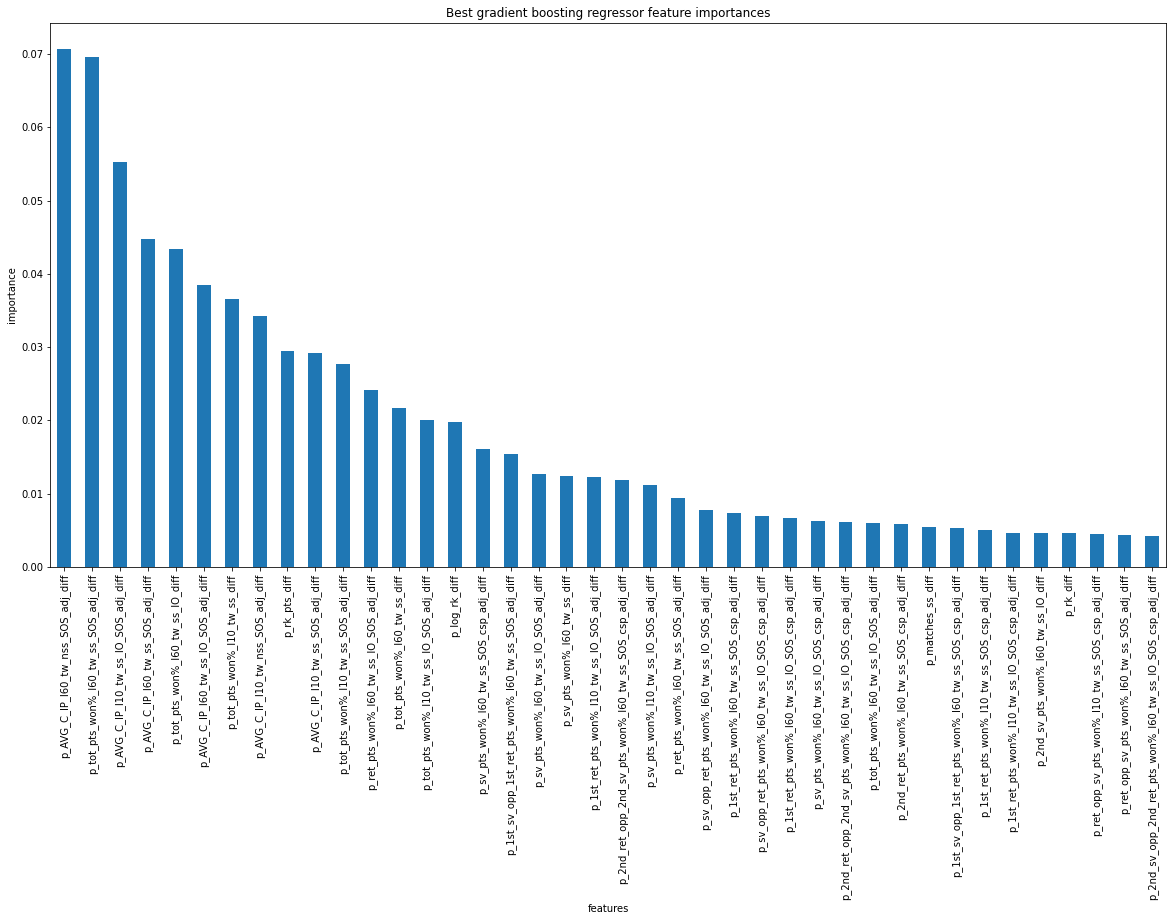

In [85]:
#Plot a barplot of the gradient boosting model's feature importances,
#assigning the `feature_importances_` attribute of 
#`gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.nlargest(40).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting regressor feature importances');

#feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nlargest(20).plot(kind='barh')

Hard Court Gradient Boosting Regressor - RMSE Train(STD)/Test with best hyperparameters
Different IWP Opening to Closing movement filter levels
2015-2019 in model (2009-2014 for stats accrual only) 

All matches included (8241.0, 2747.0)
(5.3920702375117795, 0.038953743799929906), 5.299038777366098

Filter out matches with movement >10% (8005.5, 2668.5)
(5.386220403547629, 0.08947386536655269), 5.307046385217312

Filter out matches with movement >7.5% (7572.0, 2524.0)
(5.368716582686552, 0.1471107342023909), 5.275708019851824 

Filter out matches with movement >5% (6451.5, 2150.5)
(5.345860318351832, 0.0758092820889194), 5.319251424294432

Filter out matches with movement >4% (5577.0, 1859.0)
(5.252960445114428, 0.09135028563317132), 5.453645609589488 

Filter out matches with movement >3% (4534.5, 1511.5)
(5.244755708416761, 0.13221474167720548), 5.403873277770953

Filter out matches with movement >2.5% (3915.75, 1305.25)
(5.276954011570096, 0.10712474624495678), 5.375349825953019

Filter out matches with movement >2% (3184.5, 1061.5)
(5.276868998364162, 0.11326675542188339), 5.426328000606418 

Filter out matches with movement >1.25% (2073.0, 691.0)
(5.352231618736324, 0.20662754803144975), 5.344678429792831

Clay Court Gradient Boosting Regressor - RMSE Train(STD)/Test with best hyperparameters
Different IWP Opening to Closing movement filter levels
2012-2019 in model (2009-2011 for stats accrual only) 

All matches included (5410.5, 1803.5)
(5.8295350518898434, 0.06035952193269781), 5.7805549325786885

Filter out matches with movement >10% (5205.0, 1735.0)
(5.705156322411054, 0.1196786322261165), 6.010500931726751

Filter out matches with movement >7.5% (4887.0, 1629.0)
(5.764393275369576, 0.11040028039931808), 5.792018178570522

Filter out matches with movement >5% (4084.5, 1361.5)
(5.805716897667308, 0.13977817995371952), 5.634782071665985

Filter out matches with movement >4% (3561.75, 1187.25)
(5.798275735221569, 0.06692228952308785), 5.6713375369145185

Filter out matches with movement >3% (2896.5, 965.5)
(5.687456684134477, 0.20140078802327502), 6.034778732902343

Filter out matches with movement >2.5% (2542.5, 847.5)
(5.805042732000238, 0.2054246963573721), 5.701201128435683

Filter out matches with movement >2% (2078.25, 692.75)
(5.799972800064292, 0.23100089024213047), 5.84270004623748

Filter out matches with movement >1.25% (1369.5, 456.5)
(5.823412377825655, 0.37699645965896295), 5.7103840892406 